In [2]:
# 1. Install the API Client (If you haven't already done step 1)
!pip install kaggle

# 2. Make the directory Kaggle expects
!mkdir -p ~/.kaggle

# 3. Copy the uploaded kaggle.json file into the correct directory
!cp kaggle.json ~/.kaggle/

# 4. Set secure permissions on the file (Required by Kaggle)
!chmod 600 ~/.kaggle/kaggle.json

# 5. Download the dataset (This is step 3 in your file)
!kaggle datasets download -d moodrammer/handdrawn-circuit-schematic-components

# 6. Unzip the dataset (This is step 4 in your file)
!unzip -q handdrawn-circuit-schematic-components.zip

Dataset URL: https://www.kaggle.com/datasets/moodrammer/handdrawn-circuit-schematic-components
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/4.44M [00:00<?, ?B/s]
100% 4.44M/4.44M [00:00<00:00, 738MB/s]


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
from sklearn.metrics import classification_report

# --- 1. CONFIGURATION AND UTILITY FUNCTIONS ---

# Configuration for the CNN model and data
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
EPOCHS = 30 # Set to 30 epochs

# Path setup for the real dataset (expected structure after unzipping Kaggle data)
DATASET_ROOT = pathlib.Path('./SolvaDataset_200_v3')
MODEL_SAVE_PATH = 'circuit_symbol_cnn_model.h5' # Path to save the trained model


In [4]:
# --- 2. DATA PREPARATION ---

# >>> IMPORTANT: Ensure the SolvaDataset_200_v3 folder exists before running <<<

# Load the data using Keras utility
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_ROOT,
        labels='inferred',
        label_mode='categorical',
        validation_split=0.2,
        subset='training',
        seed=1337,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='rgb'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_ROOT,
        labels='inferred',
        label_mode='categorical',
        validation_split=0.2,
        subset='validation',
        seed=1337,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='rgb'
    )

    # --- Dynamically determine classes from the dataset folders ---
    CLASSES = train_ds.class_names
    NUM_CLASSES = len(CLASSES)
    print(f"Inferred {NUM_CLASSES} classes from dataset folders: {CLASSES}")

except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"Failed to load dataset from {DATASET_ROOT}.")
    print("Please ensure you have run the Kaggle download and unzip commands successfully in a preceding cell.")
    print(f"Error details: {e}")
    exit()

# Normalize pixel values to [0, 1]
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing and optimization
train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)



Found 2952 files belonging to 15 classes.
Using 2362 files for training.
Found 2952 files belonging to 15 classes.
Using 590 files for validation.
Inferred 15 classes from dataset folders: ['Ammeter', 'ac_src', 'battery', 'cap', 'curr_src', 'dc_volt_src_1', 'dc_volt_src_2', 'dep_curr_src', 'dep_volt', 'diode', 'gnd_1', 'gnd_2', 'inductor', 'resistor', 'voltmeter']


In [5]:
### Cell 3: Model Definition and Summary

#This cell defines the CNN architecture, including data augmentation, grayscale conversion, and the special layer for CAM visualization (`conv3_cam_layer`).

#```python
# --- 3. CNN MODEL DEFINITION (With Data Augmentation) ---

# Data Augmentation layer: Crucial for hand-drawn data to simulate variation
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=(-0.1, 0.1)),
        layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="data_augmentation",
)

def build_cnn_model(input_shape, num_classes):
    """Defines a custom CNN architecture for classification."""
    model = keras.Sequential([
        keras.Input(shape=input_shape),

        # Convert 3-channel RGB data back to 1-channel Grayscale for the CNN
        layers.Lambda(tf.image.rgb_to_grayscale, name='rgb_to_grayscale'),

        # Apply Data Augmentation only during training
        data_augmentation,

        # Initial Convolutional Block
        layers.Conv2D(32, 3, padding='same', activation='relu', name="conv1"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Mid-level Feature Extraction
        layers.Conv2D(64, 3, padding='same', activation='relu', name="conv2"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        # Deep Feature Extraction (CAM Layer)
        layers.Conv2D(128, 3, padding='same', activation='relu', name="conv3_cam_layer"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Classification Head
        layers.Dense(num_classes, activation='softmax', name="classifier_output")
    ], name="CircuitSymbolRecognitionCNN")

    return model

# Build the model and display summary
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
model = build_cnn_model(input_shape, NUM_CLASSES)
model.summary()


Model: "CircuitSymbolRecognitionCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rgb_to_grayscale (Lambda)       │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_cam_layer (Conv2D)        │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,503 (373.06 KB)

 Trainable params: 95,055 (371.31 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
### Cell 4: Training and Saving

#This cell compiles and trains the model for the requested 30 epochs and saves the resulting model file.

#```python
# --- 4. MODEL TRAINING & SAVING ---

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\n--- Starting Model Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
print("--- Training Complete ---\n")

# Save the model
try:
    model.save(MODEL_SAVE_PATH)
    print(f"Model successfully saved to: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Warning: Could not save model. Error: {e}")


--- Starting Model Training ---
Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.2284 - loss: 2.3917 - val_accuracy: 0.1000 - val_loss: 2.9466
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3127 - loss: 2.0441 - val_accuracy: 0.0712 - val_loss: 5.0712
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3826 - loss: 1.9102 - val_accuracy: 0.0712 - val_loss: 10.9673
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4079 - loss: 1.7727 - val_accuracy: 0.0712 - val_loss: 15.6899
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4621 - loss: 1.7023 - val_accuracy: 0.0712 - val_loss: 19.0963
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5386 - loss: 1.5525 - val_accuracy: 0.0712 - val_loss: 20.1384
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5389 - loss: 1.5086 - val_accuracy: 0.0712 - val_loss: 10.9805
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5717 - l

--- Training Complete ---

Model successfully saved to: circuit_symbol_cnn_model.h5


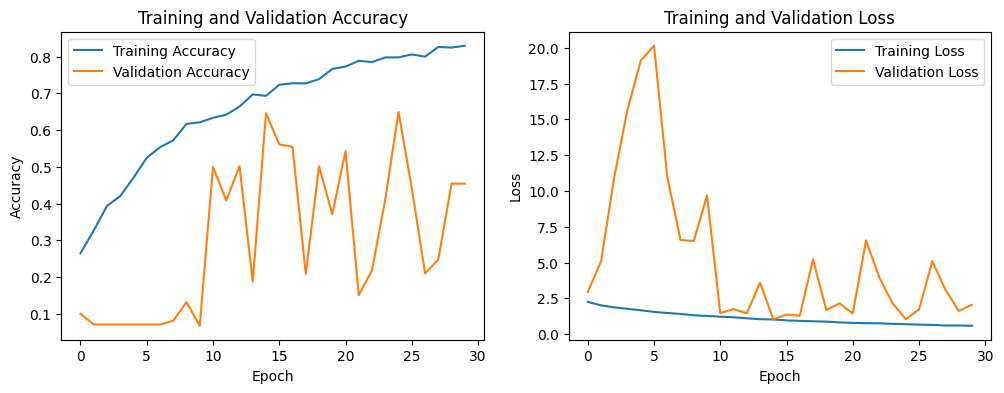


--- Model Evaluation (Precision, Recall, F1-Score) ---

Classification Report:
               precision    recall  f1-score   support

      Ammeter       0.25      0.97      0.40        34
       ac_src       1.00      0.62      0.76        39
      battery       1.00      0.28      0.43        40
          cap       0.45      0.63      0.53        41
     curr_src       0.33      1.00      0.50        34
dc_volt_src_1       0.54      0.83      0.66        48
dc_volt_src_2       0.00      0.00      0.00        35
 dep_curr_src       1.00      0.03      0.05        38
     dep_volt       1.00      0.08      0.15        48
        diode       0.89      0.20      0.33        40
        gnd_1       0.26      0.89      0.40        28
        gnd_2       0.95      0.85      0.90        46
     inductor       1.00      0.02      0.05        42
     resistor       1.00      0.15      0.27        39
    voltmeter       0.79      0.68      0.73        38

     accuracy                         

In [32]:
# --- 5. EVALUATION, HISTORY PLOTTING, AND CAM VISUALIZATION ---

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- 5.1 PRECISION, RECALL, F1-SCORE, AND CONFUSION MATRIX (IMPLICIT) ---
print("\n--- Model Evaluation (Precision, Recall, F1-Score) ---")

# 1. Collect true labels (y_true) and predictions (y_pred) from the validation dataset
y_true = []
y_pred_probs = []

# Loop through the validation dataset
for images, labels in val_ds:
    # y_true is the ground truth label index
    y_true.extend(np.argmax(labels.numpy(), axis=1))

    # Predict the batch using the trained model
    predictions = model.predict(images, verbose=0)
    y_pred_probs.extend(predictions)

# Convert predicted probabilities to class indices (y_pred is the predicted label index)
y_pred = np.argmax(np.array(y_pred_probs), axis=1)
y_true = np.array(y_true)

# 2. Generate the Classification Report
# This report calculates Precision, Recall, and F1-Score for each class.
report = classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0)
print("\nClassification Report:")
print(report)


# Function to generate CAM for model visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Computes and returns a Grad-CAM heatmap using a robust, non-Functional API approach."""

    # --- DEFINITIVE FIX: Get Tensors directly using two simpler models/tensors ---

    # 1. Create a model that outputs ONLY the last convolutional layer.
    conv_layer_model = tf.keras.models.Model(
        model.inputs, model.get_layer(last_conv_layer_name).output
    )

    # 2. Create a model that outputs ONLY the final prediction layer (logits).
    classifier_input = tf.keras.Input(shape=model.get_layer(last_conv_layer_name).output.shape[1:])

    # Re-route the rest of the classifier head manually:
    x = classifier_input

    # Traverse the layers after the last_conv_layer_name:
    # Find the index of the CAM layer
    layer_names = [layer.name for layer in model.layers]
    cam_layer_index = layer_names.index(last_conv_layer_name)

    # Apply layers from the CAM layer onwards to the classifier input
    for layer in model.layers[cam_layer_index + 1:]:
        x = layer(x)

    classifier_model = tf.keras.models.Model(classifier_input, x)
    # --------------------------------------------------------------------------

    with tf.GradientTape() as tape:
        # Cast the inputs to ensure the tape can watch them
        last_conv_layer_output = conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        # Pass the convolution output through the rest of the model's layers
        preds = classifier_model(last_conv_layer_output)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients of the predicted class with respect to the convolution output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Build the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


def display_cam(model, dataset, class_names, layer_name="conv3_cam_layer", index=0):
    """
    Picks a specific image from the validation set by index and displays its CAM.
    'index' specifies which image from the validation set to display.
    """

    # Convert the validation dataset into a flat list for easy indexing
    # This is inefficient for huge datasets, but necessary for simple index-based access.
    all_images = []
    all_labels = []

    # Note: We use list(dataset) to force a full read, which can be slow.
    # A more efficient approach for large datasets would be to use tf.data.Dataset.skip() and .take(1).
    for images, labels in dataset:
        all_images.append(images)
        all_labels.append(labels)

    images_tensor = tf.concat(all_images, axis=0)
    labels_tensor = tf.concat(all_labels, axis=0)

    if index >= images_tensor.shape[0] or index < 0:
        print(f"Index {index} is out of bounds. The dataset only contains {images_tensor.shape[0]} images.")
        # Fall back to a random image if index is invalid
        index = np.random.randint(0, images_tensor.shape[0])
        print(f"Displaying random image at index {index} instead.")

    # Select the specific sample image and label
    sample_img = images_tensor[index]
    sample_label_index = np.argmax(labels_tensor[index])
    sample_class = class_names[sample_label_index]

    img_array = tf.expand_dims(sample_img, axis=0)

    # Generate the heatmap
    # Note: We must call the model here to stabilize the input shape for make_gradcam_heatmap's models.
    model.predict(img_array, verbose=0)
    heatmap = make_gradcam_heatmap(img_array, model, layer_name, pred_index=sample_label_index)

    heatmap = np.uint8(255 * heatmap)

    img_display = (sample_img.numpy() * 255).astype(np.uint8)

    # Convert the original RGB sample image to grayscale for display simplicity
    img_grayscale = tf.image.rgb_to_grayscale(img_display)
    # We need 3 channels for imshow color stacking
    img_rgb_for_display = np.stack([img_grayscale.numpy()[:, :, 0]] * 3, axis=-1)

    plt.figure(figsize=(8, 4))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(img_rgb_for_display)
    ax.set_title(f"Original Image\n(Predicted {sample_class})")
    ax.axis("off")

    ax = plt.subplot(1, 2, 2)
    ax.imshow(img_rgb_for_display)
    ax.imshow(tf.image.resize(heatmap[..., tf.newaxis], (IMG_HEIGHT, IMG_WIDTH)),
               cmap="jet", alpha=0.4) # Overlay heatmap
    ax.set_title(f"CAM Visualization\n(Focus on Symbol)")
    ax.axis("off")

    plt.suptitle(f"Class Activation Map (CAM) Visualization for Index {index}", fontsize=14)
    plt.show()
    # The loop is gone; the function displays only the requested index.


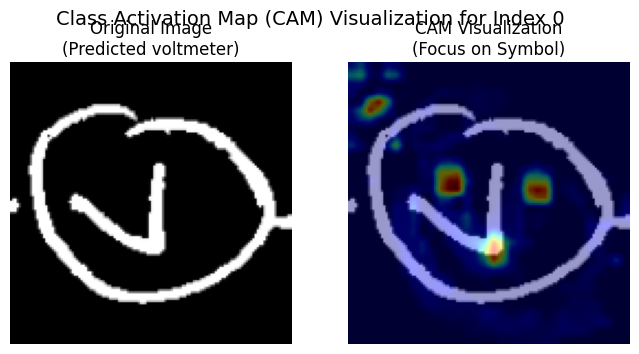


CAM visualization successfully displayed above.


In [33]:
# --- 6. RUN CAM VISUALIZATION ---
# This executes the display_cam function defined in Cell 5.

try:
    # This calls the function using the trained model, validation data, and class names
    display_cam(model, val_ds, CLASSES)
    print("\nCAM visualization successfully displayed above.")
except NameError:
    print("Error: 'display_cam' or required variables (model, val_ds, CLASSES) are not defined. Ensure Cells 1-5 have run successfully.")
except Exception as e:
    print(f"An error occurred during CAM display: {e}")


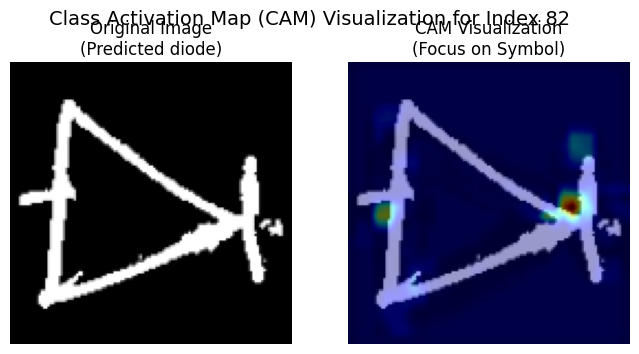


CAM visualization successfully displayed for image index: 82


In [36]:
# --- 6. RUN CAM VISUALIZATION ---
# This executes the display_cam function defined in Cell 5.

# Specify the index of the image you want to visualize (e.g., the 50th image is index 49)
IMAGE_INDEX_TO_DISPLAY = 82

try:
    # This calls the function using the trained model, validation data, and class names
    # NOTE: The display_cam function MUST be updated in Cell 5 to accept this index.
    display_cam(model, val_ds, CLASSES, index=IMAGE_INDEX_TO_DISPLAY)
    print(f"\nCAM visualization successfully displayed for image index: {IMAGE_INDEX_TO_DISPLAY}")
except NameError:
    print("Error: 'display_cam' or required variables (model, val_ds, CLASSES) are not defined. Ensure Cells 1-5 have run successfully.")
except Exception as e:
    print(f"An error occurred during CAM display: {e}")
